In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.regression import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Create a spark session
spark = (
    SparkSession.builder.appName("Modelling monthly revenue")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "12g")
    .config("spark.driver.maxResultSize", "16G")
    .config("spark.executor.memory", "16G")
    .config("spark.sql.files.maxPartitionBytes", "64MB")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.network.timeout", "600s")
    .getOrCreate()
)

24/10/05 04:37:36 WARN Utils: Your hostname, codespaces-c6855a resolves to a loopback address: 127.0.0.1; using 10.0.0.128 instead (on interface eth0)
24/10/05 04:37:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/05 04:37:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/05 04:37:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/10/05 04:37:37 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/10/05 04:37:37 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [3]:
transactions = spark.read.parquet('../data/curated/all_details/*')

In [4]:
# Group by month and merchant, aggregating the sum of dollar_value and the count of transactions
merchant_monthly = transactions.groupBy(F.date_format(F.col('order_datetime'), 'yyyy-MM'), 'merchant_abn').agg(F.sum('dollar_value'))
count_transactions = transactions.groupBy(F.date_format(F.col('order_datetime'), 'yyyy-MM'), 'merchant_abn').agg(F.count('dollar_value'))
merchant_monthly = merchant_monthly.join(count_transactions, ['date_format(order_datetime, yyyy-MM)', 'merchant_abn'], how='inner')
merchant_monthly = merchant_monthly.withColumnRenamed('sum(dollar_value)', 'monthly_revenue')
merchant_monthly = merchant_monthly.withColumnRenamed('count(dollar_value)', 'number_transactions')
merchant_monthly.show()

In [5]:
merchant = spark.read.parquet('../data/curated/part_1/clean_merchant.parquet')
merchant = merchant.withColumn('average_revenue', F.col('sum(dollar_value)') / F.col('count(dollar_value)'))
# merchant.show()

In [ ]:
merchant_with_revenue = merchant.join(merchant_monthly, on ='merchant_abn', how='left')
omitted_merchants = merchant.join(merchant_monthly, on ='merchant_abn', how='left_anti')
# omitted_merchants.count()

In [7]:
merchant_with_revenue = merchant_with_revenue.withColumnRenamed('sum(dollar_value)', 'total_revenue').withColumnRenamed('date_format(order_datetime, yyyy-MM)', 'month_year')
# merchant_with_revenue.show()

24/10/05 04:37:54 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [8]:
# Creating a month column
merchant_with_revenue = merchant_with_revenue.withColumn('month', F.month(F.col('month_year')))

In [9]:
merchant_with_revenue.show()

+------------+------------+--------------------+-------------+---------+------------------+-------------------+-----------------+------------------+-----------------+----------+------------------+-------------------+-----+
|merchant_abn|        name|               goods|revenue_level|take_rate|     total_revenue|count(dollar_value)|        log_ratio|  unscaled_earning|  average_revenue|month_year|   monthly_revenue|number_transactions|month|
+------------+------------+--------------------+-------------+---------+------------------+-------------------+-----------------+------------------+-----------------+----------+------------------+-------------------+-----+
| 12516851436|Mollis Corp.|watch, clock, and...|            a|     6.71|32325.484349738053|                210|5.036503656560932|2169.0399998674234|153.9308778558955|   2021-11| 2545.733415789338|                 18|   11|
| 12516851436|Mollis Corp.|watch, clock, and...|            a|     6.71|32325.484349738053|                2

In [9]:
# importing window 
from pyspark.sql.window import Window

# Creating a month since first transaction column for each merchant
merchant_with_revenue = merchant_with_revenue.withColumn('first_transaction', F.min('month_year').over(Window.partitionBy('merchant_abn')))
merchant_with_revenue = merchant_with_revenue.withColumn('month_since_first_transaction', F.months_between(F.col('month_year'), F.col('first_transaction')))

In [11]:
merchant_with_revenue.show()

+------------+-------------+--------------------+-------------+---------+-----------------+-------------------+-----------------+------------------+------------------+----------+------------------+-------------------+-----+-----------------+-----------------------------+
|merchant_abn|         name|               goods|revenue_level|take_rate|    total_revenue|count(dollar_value)|        log_ratio|  unscaled_earning|   average_revenue|month_year|   monthly_revenue|number_transactions|month|first_transaction|month_since_first_transaction|
+------------+-------------+--------------------+-------------+---------+-----------------+-------------------+-----------------+------------------+------------------+----------+------------------+-------------------+-----+-----------------+-----------------------------+
| 10023283211|Felis Limited|furniture, home f...|            e|     0.18|703277.7114509277|               3261|5.373717954622449|1265.8998806116697|215.66320498341847|   2022-07|40122.

In [10]:
# Creating montly earning column
merchant_with_revenue = merchant_with_revenue.withColumn('monthly_earning', F.col('monthly_revenue') * F.col('take_rate')/100)

In [13]:
merchant_with_revenue.show()

+------------+-------------+--------------------+-------------+---------+-----------------+-------------------+-----------------+------------------+------------------+----------+------------------+-------------------+-----+-----------------+-----------------------------+------------------+
|merchant_abn|         name|               goods|revenue_level|take_rate|    total_revenue|count(dollar_value)|        log_ratio|  unscaled_earning|   average_revenue|month_year|   monthly_revenue|number_transactions|month|first_transaction|month_since_first_transaction|   monthly_earning|
+------------+-------------+--------------------+-------------+---------+-----------------+-------------------+-----------------+------------------+------------------+----------+------------------+-------------------+-----+-----------------+-----------------------------+------------------+
| 10023283211|Felis Limited|furniture, home f...|            e|     0.18|703277.7114509277|               3261|5.37371795462244

In [11]:
# Creating sin and cos columns for month
merchant_with_revenue = merchant_with_revenue.withColumn('month_sin', F.sin(2 * 3.14 * F.col('month') / 12))
merchant_with_revenue = merchant_with_revenue.withColumn('month_cos', F.cos(2 * 3.14 * F.col('month') / 12))

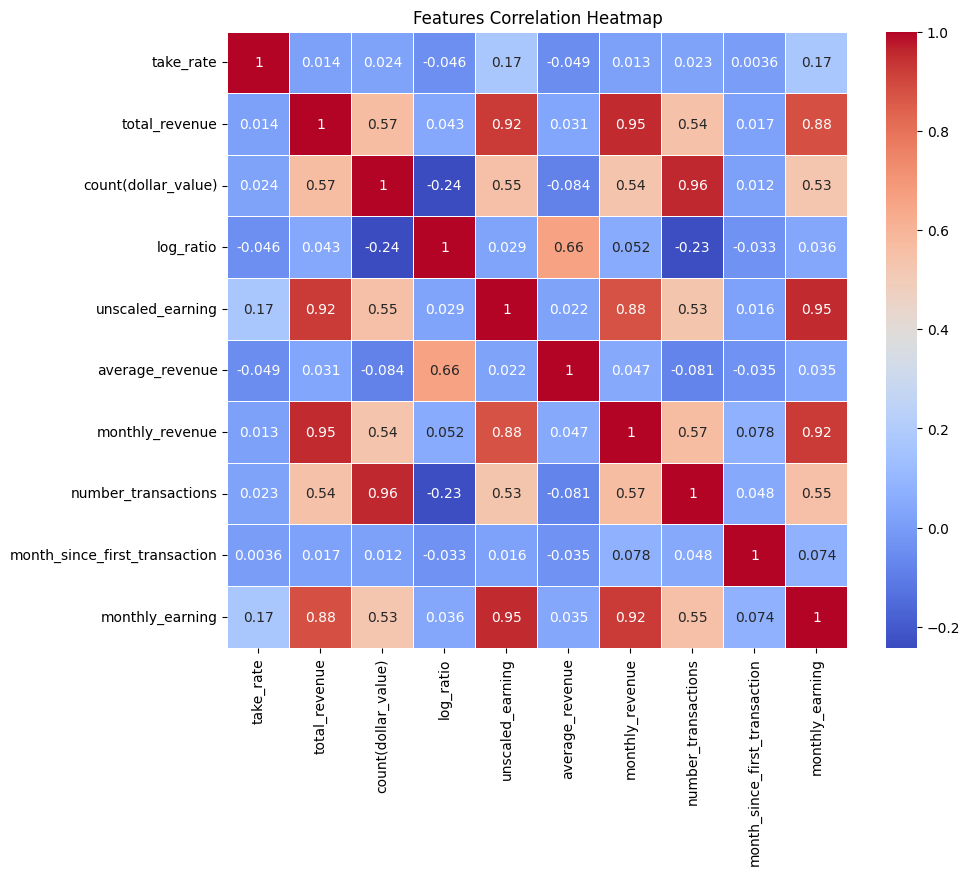

In [18]:
# Correlation analysis

# Check numerical columns
numerical_columns = ['take_rate', 'total_revenue', 'count(dollar_value)', 'log_ratio', 'unscaled_earning', 'average_revenue', 'monthly_revenue', 'number_transactions', 'month_since_first_transaction', 'monthly_earning']

# Convert the Spark DataFrame to a Pandas DataFrame for correlation analysis
merchant_with_revenue_pd = merchant_with_revenue.select(numerical_columns).toPandas()

# Calculate the correlation matrix for the numerical columns
corr_df = merchant_with_revenue_pd.corr()

# Plot the heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Features Correlation Heatmap')
plt.savefig("../plots/Features_Correlation_Heatmap.png")
plt.show()

In [12]:
# Partitioning the data into training and testing
train = merchant_with_revenue.filter(F.col('month_year') < '2022-07')
test = merchant_with_revenue.filter(F.col('month_year') >= '2022-07')

revenue_levels = ['a', 'b', 'c', 'd', 'e']

# Setting up the pipeline for linear regression
assembler = VectorAssembler(inputCols=[ 'month_since_first_transaction', 'total_revenue', 'count(dollar_value)', 'month_sin', 'month_cos'], outputCol='features')
lr = LinearRegression(featuresCol='features', labelCol='monthly_revenue', elasticNetParam=1)

# Create the pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Define the parameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

# Define the evaluator 
evaluator = RegressionEvaluator(labelCol='monthly_revenue', predictionCol='prediction', metricName='rmse')

# Fit the model using CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [27]:
models = {}

for level in revenue_levels:
    # Filter data for the current revenue level
    level_data = train.filter(F.col('revenue_level') == level)
    # Train the model for the revenue level
    model = crossval.fit(level_data)
    # Store the model
    models[level] = model
    # save the model to disk
    model.bestModel.save(f'../models/revenue_linear_regression_{level}')

24/10/01 10:52:44 WARN CacheManager: Asked to cache already cached data.
24/10/01 10:52:44 WARN CacheManager: Asked to cache already cached data.


In [28]:
for level in revenue_levels:
    # load the model
    best_model = PipelineModel.load(f'../models/revenue_linear_regression_{level}')
    test_data = test.filter(F.col('revenue_level') == level)
    predictions = best_model.transform(test_data)
    
    # Apply the inverse log (exponentiate) to get the actual predictions for monthly revenue
    predictions = predictions.withColumn('predicted_monthly_revenue', F.exp(F.col('prediction')))
    
    rmse = evaluator.evaluate(predictions)
    print(f"RMSE for revenue level {level}: {rmse}")

RMSE for revenue level a: 16676.625330853018


RMSE for revenue level b: 18308.649982903804


RMSE for revenue level c: 16570.747139353567


RMSE for revenue level d: 9413.344273160841


RMSE for revenue level e: 17645.15499515905


In [29]:
# Similar random forest model but for log-transformed revenue
pipeline_rf = Pipeline(stages=[assembler, RandomForestRegressor(featuresCol='features', labelCol='monthly_revenue')])
paramGrid_rf = ParamGridBuilder() \
    .addGrid(RandomForestRegressor.numTrees, [10, 20]) \
    .addGrid(RandomForestRegressor.maxDepth, [5, 10]) \
    .build()

crossval_rf = CrossValidator(estimator=pipeline_rf,
                            estimatorParamMaps=paramGrid_rf,
                            evaluator=evaluator,
                            numFolds=3)

In [30]:
models = {}

for level in revenue_levels:
    # Filter data for the current revenue level
    level_data = train.filter(F.col('revenue_level') == level)
    # Train the model for the revenue level
    model = crossval_rf.fit(level_data)
    # Store the model
    models[level] = model
    # save the model to disk
    model.bestModel.save(f'../models/revenue_random_forest_{level}')

In [31]:
for level in revenue_levels:
    # load the model
    best_model = PipelineModel.load(f'../models/revenue_random_forest_{level}')
    test_data = test.filter(F.col('revenue_level') == level)
    predictions = best_model.transform(test_data)
    
    # Apply the inverse log to get actual monthly revenue predictions
    predictions = predictions.withColumn('predicted_monthly_revenue', F.exp(F.col('prediction')))
    
    rmse = evaluator.evaluate(predictions)
    print(f"RMSE for revenue level {level}: {rmse}")

RMSE for revenue level a: 23220.046010048096


RMSE for revenue level b: 21947.228156594563


RMSE for revenue level c: 24247.152612100675


RMSE for revenue level d: 8814.562872109873


RMSE for revenue level e: 13894.971081812313


In [13]:
# Now getting the predictions for all merchants for the next year (2023-01 to 2023-12)
# Total Revenue, take rate and 'count(dollar_value)' i.e. number of total transactions are same.
# We can use the same model for all merchants.
# We will create a new dataframe with all the months from 2023-01 to 2023-12 and all the merchants and then predict the monthly revenue for each merchant for each month.
# We know months since first transaction will be 24 to 35 for january 2023 to december 2023 respectively.

# Create a dataframe with all the months from 2023-01 to 2023-12
months = ['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12']
months_df = spark.createDataFrame([(month,) for month in months], ['month_year'])

# Adding all merchants to the dataframe
all_merchants = merchant.select('merchant_abn').distinct()
months_df = months_df.crossJoin(all_merchants)

# Adding the total revenue, take rate and count(dollar_value) columns
months_df = months_df.join(merchant, on='merchant_abn', how='left')

# Adding the month column
months_df = months_df.withColumn('month', F.month(F.col('month_year')))
months_df = months_df.withColumn('month_sin', F.sin(2 * 3.14 * F.col('month') / 12))
months_df = months_df.withColumn('month_cos', F.cos(2 * 3.14 * F.col('month') / 12))

# Adding the month since first transaction column
months_df = months_df.withColumn('month_since_first_transaction', 23 + F.col('month'))

months_df.show()

+------------+----------+--------------------+--------------------+-------------+---------+------------------+-------------------+------------------+------------------+------------------+-----+------------------+-----------------+-----------------------------+
|merchant_abn|month_year|                name|               goods|revenue_level|take_rate| sum(dollar_value)|count(dollar_value)|         log_ratio|  unscaled_earning|   average_revenue|month|         month_sin|        month_cos|month_since_first_transaction|
+------------+----------+--------------------+--------------------+-------------+---------+------------------+-------------------+------------------+------------------+------------------+-----+------------------+-----------------+-----------------------------+
| 12516851436|   2023-01|        Mollis Corp.|watch, clock, and...|            a|     6.71|32325.484349738053|                210| 5.036503656560932|2169.0399998674234| 153.9308778558955|    1|0.4997701026431024|0.866

In [14]:
# Renaming the sum(dollar_value) column to total_revenue
months_df = months_df.withColumnRenamed('sum(dollar_value)', 'total_revenue')

We can see that the linear model has a better performance than random forest, so we use it to predict future data.

In [15]:
# We will add a predicted_monthly_revenue column to the dataframe
# We will use the best linear regression model for each revenue level to predict the monthly revenue for each merchant for each month

for level in revenue_levels:
    # Load the model
    best_model = PipelineModel.load(f'../models/revenue_linear_regression_{level}')
    # Predict the monthly revenue for each merchant for each month
    predictions = best_model.transform(months_df)

predictions.show()

+------------+----------+--------------------+--------------------+-------------+---------+------------------+-------------------+------------------+------------------+------------------+-----+------------------+-----------------+-----------------------------+--------------------+------------------+
|merchant_abn|month_year|                name|               goods|revenue_level|take_rate|     total_revenue|count(dollar_value)|         log_ratio|  unscaled_earning|   average_revenue|month|         month_sin|        month_cos|month_since_first_transaction|            features|        prediction|
+------------+----------+--------------------+--------------------+-------------+---------+------------------+-------------------+------------------+------------------+------------------+-----+------------------+-----------------+-----------------------------+--------------------+------------------+
| 12516851436|   2023-01|        Mollis Corp.|watch, clock, and...|            a|     6.71|32325.

24/10/05 04:39:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/10/05 04:39:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [16]:
# Storing the predictions in a parquet file
predictions.write.mode('overwrite').parquet('../data/curated/predicted_monthly_revenue.parquet')